In [43]:
import os
import numpy as np
import torch
import pyro

from prodlda import ProdLDA
from save_load_pyro_model import load_pyro_model

In [7]:
torch.set_grad_enabled(False)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
smoke_test = False
batch_size = 32
learning_rate = 1e-3
num_epochs = 50 if not smoke_test else 1

pyro.clear_param_store()


prodLDA = ProdLDA(
    vocab_size=24576,
    num_topics=300,
    hidden=300 if not smoke_test else 10,
    dropout=0.2
)
prodLDA.to(DEVICE)

MODEL_CHECKPOINT_DIR = "prodlda_checkpoints"
MODEL_FILE = "prodlda_model_20241027_184018.pt"
prodLDA, _ = load_pyro_model(prodLDA, os.path.join(MODEL_CHECKPOINT_DIR, MODEL_FILE))

In [12]:
beta = prodLDA.beta()

In [13]:
from matplotlib import pyplot as plt

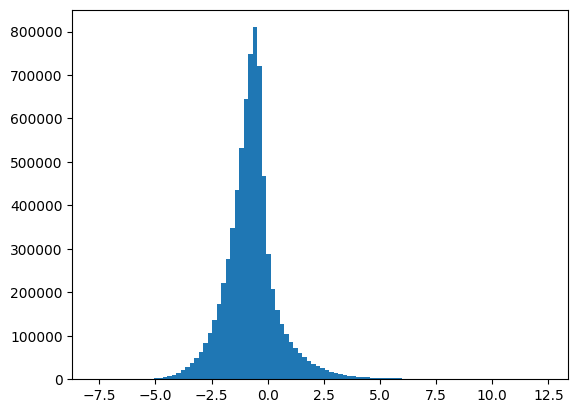

In [15]:
plt.hist(beta.flatten().numpy(), bins=100);

In [16]:
topic0 = beta[0].numpy()

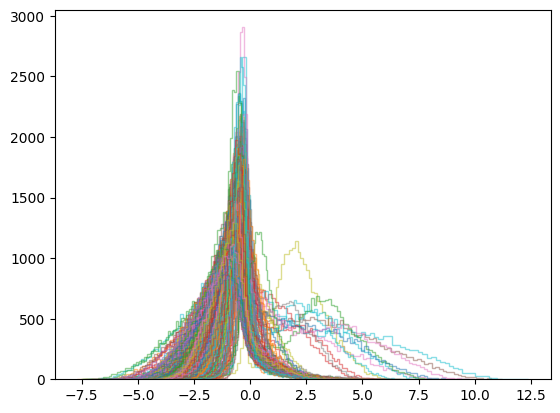

In [18]:
for topic in range(beta.shape[0]):
    plt.hist(beta[topic].numpy(), bins=100, alpha=0.5, label=f"Topic {topic}", histtype="step");


In [35]:
topic = 10
sorted_, idxs = torch.sort(beta[topic], descending=True)
print(f"Topic {topic}")
print("Top 10 words:")
print(sorted_[:10])
print(idxs[:10])

print("Bottom 10 words:")
print(sorted_[-10:])
print(idxs[-10:])

print("\n===============")
print("Topic = Verbs?")
print("===============")


Topic 10
Top 10 words:
tensor([5.3994, 5.0075, 4.9068, 4.7544, 4.7380, 4.6897, 4.6761, 4.6739, 4.5883,
        4.5613])
tensor([20945,  1841,  8763,  6255, 12795, 19946, 13900,  2926, 19616,  4828])
Bottom 10 words:
tensor([-3.2653, -3.2654, -3.2721, -3.2845, -3.3160, -3.4238, -3.4529, -3.4750,
        -3.4776, -3.7083])
tensor([ 5562, 18503,  4943,  7180, 13418,  5766, 22147, 23345, 13343, 18339])

Topic = Verbs?


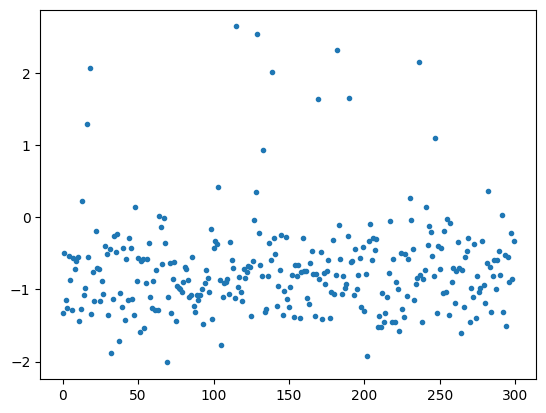

In [21]:
plt.plot(beta.numpy().mean(1),'.')

In [41]:
torch.sort(beta.mean(-1))

torch.return_types.sort(
values=tensor([-0.4154, -0.3531, -0.2681, -0.2536, -0.2398, -0.2388, -0.2338, -0.2163,
        -0.2011, -0.1897, -0.1835, -0.1829, -0.1773, -0.1466, -0.1078, -0.0685,
         0.0105,  0.0526,  0.3952,  0.5556]),
indices=tensor([ 2, 12, 14, 10,  6, 15, 18,  1, 13, 19,  9, 11,  7, 16, 17,  4,  5,  3,
         0,  8]))

In [37]:
beta = beta.numpy()

In [41]:
beta.shape

(300, 24576)

In [51]:
# Get the top N highest values for each latent across all topics
n_highest = 2  # Look for words that are important in at least 2 topics
top_topics_per_latent = np.argpartition(beta, -n_highest, axis=0)[-n_highest:]

# Find latents where the top attributions are significantly high
# We can define "high" as being above some threshold
threshold = 0.5  # Adjust this value based on your data distribution
high_values = beta[top_topics_per_latent, np.arange(beta.shape[1])]
significant_latents = np.where(np.all(high_values > threshold, axis=0))[0]

# Print results
for latent_idx in significant_latents[:10]:  # Show first 10 results
    top_topic_indices = top_topics_per_latent[:, latent_idx]
    values = beta[top_topic_indices, latent_idx]
    print(f"\nLatent {latent_idx}:")
    for topic_idx, value in zip(top_topic_indices, values):
        print(f"  Topic {topic_idx}: {value:.3f}")


Latent 0:
  Topic 285: 3.233
  Topic 115: 3.935

Latent 1:
  Topic 115: 3.761
  Topic 236: 3.970

Latent 2:
  Topic 115: 4.858
  Topic 236: 5.517

Latent 3:
  Topic 139: 5.394
  Topic 129: 8.256

Latent 4:
  Topic 79: 2.810
  Topic 236: 2.922

Latent 5:
  Topic 115: 4.730
  Topic 129: 5.347

Latent 6:
  Topic 48: 2.905
  Topic 231: 3.560

Latent 7:
  Topic 236: 3.911
  Topic 16: 5.929

Latent 8:
  Topic 209: 2.885
  Topic 18: 3.112

Latent 9:
  Topic 169: 2.816
  Topic 129: 2.859


In [64]:
# Parameters
n_highest = 10 # Look for words that are important in exactly 2 topics
high_threshold = 4.0  # Minimum value for "high" attribution
low_threshold = 3.0 # Maximum value for "low" attribution in other topics

# Get the top N highest values for each latent
top_topics_per_latent = np.argpartition(beta, -n_highest, axis=0)[-n_highest:]
bottom_topics_per_latent = np.argpartition(beta, -n_highest, axis=0)[:-n_highest]

# Find latents where:
# 1. Top attributions are significantly high
# 2. All other attributions are low
high_values = beta[top_topics_per_latent, np.arange(beta.shape[1])]
low_values = beta[bottom_topics_per_latent, np.arange(beta.shape[1])]

significant_latents = np.where(
    (np.all(high_values > high_threshold, axis=0)) &  # Top values are high
    (np.all(low_values < low_threshold, axis=0))      # All other values are low
)[0]

# Print results
for latent_idx in significant_latents[:10]:  # Show first 10 results
    all_values = beta[:, latent_idx]
    print(f"\nLatent {latent_idx}:")
    print(f"  Top values:")
    top_indices = top_topics_per_latent[:, latent_idx]
    for topic_idx in top_indices:
        print(f"    Topic {topic_idx}: {all_values[topic_idx]:.3f}")
    print(f"  Mean of other values: {low_values[:, latent_idx].mean():.3f}")


Latent 8885:
  Top values:
    Topic 169: 4.141
    Topic 139: 4.143
    Topic 247: 4.320
    Topic 18: 4.413
    Topic 190: 7.107
    Topic 16: 4.871
    Topic 129: 5.302
    Topic 115: 7.113
    Topic 236: 7.221
    Topic 182: 5.216
  Mean of other values: -1.587

Latent 10694:
  Top values:
    Topic 18: 4.104
    Topic 133: 4.123
    Topic 169: 4.312
    Topic 115: 8.259
    Topic 190: 4.499
    Topic 16: 5.450
    Topic 182: 5.723
    Topic 236: 6.397
    Topic 139: 5.391
    Topic 129: 7.487
  Mean of other values: -1.788

Latent 17580:
  Top values:
    Topic 18: 4.409
    Topic 247: 4.450
    Topic 139: 4.523
    Topic 169: 4.587
    Topic 133: 4.928
    Topic 16: 5.694
    Topic 115: 5.702
    Topic 129: 9.204
    Topic 236: 6.285
    Topic 190: 8.167
  Mean of other values: -2.133

Latent 17995:
  Top values:
    Topic 133: 4.243
    Topic 139: 6.521
    Topic 16: 8.555
    Topic 169: 5.986
    Topic 115: 6.101
    Topic 236: 8.450
    Topic 129: 10.352
    Topic 18: 5.003
 

- 8885 - "neo-"
- 10694 - "couple"

hmm.. I think I might need to normalise things a bit.

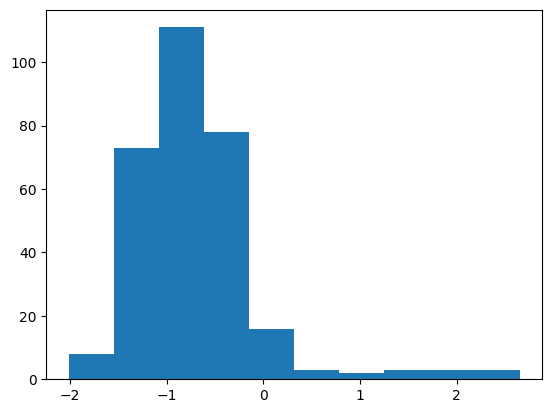

In [77]:
plt.hist(beta.mean(1));

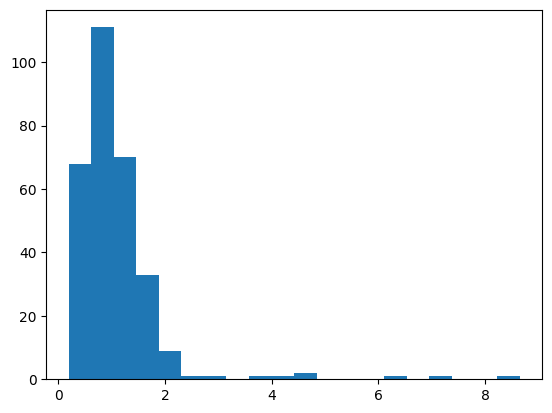

In [88]:
plt.hist(beta.var(1),bins=20);

In [87]:
np.argsort(beta.var(1))

array([ 67, 111,  65, 189, 206, 299, 101, 192, 297, 243,  64, 148, 232,
       289, 130, 293, 183,  29, 224,  44, 253,  98, 268,  34, 241,  13,
       229, 159, 291, 231, 205, 204,  40, 203, 102, 278, 257, 269,  22,
        81, 112, 100,  31, 255, 242, 282, 127, 124,  68,  57, 176, 208,
        50, 244, 281, 194, 249,  53, 273, 140,   1, 219, 207,  56, 262,
       196, 179, 145, 175,  35,  48, 230, 144, 227, 250, 201, 259,  45,
        80, 171,  52,  95, 137, 191, 290, 155,  28, 164,  86, 141, 237,
       258, 251, 295,  42, 240, 128,  17,  66, 288,  79, 165, 217, 212,
       123, 271,  74, 184, 160, 199, 173, 216, 161, 267, 156, 131, 197,
       122,   4, 195, 279, 138, 283, 254, 285,  10,  82, 154, 117, 143,
        14, 222, 126, 187,   9,  62,  73, 277,  96, 178,  71, 215, 188,
       152, 245, 235, 132,  23, 113, 186,  26, 121,  58,   5, 265, 162,
       263,  70,  20,   8, 185,  38, 234,  76, 170, 158, 116, 168, 246,
        55, 287, 166, 136, 275,  33, 286, 276, 298,  24,  15, 17

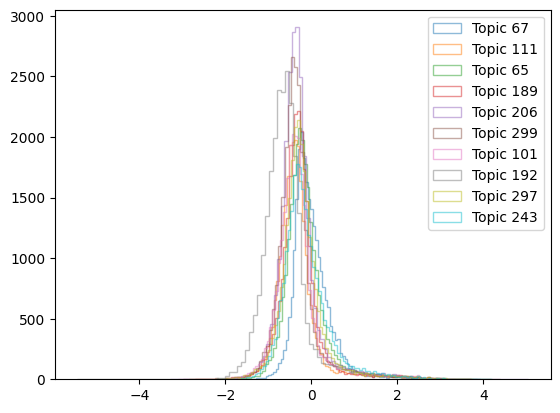

In [94]:
low_var_topics = np.argsort(beta.var(1))[:10]
for topic in low_var_topics:
    plt.hist(beta[topic], bins=100, alpha=0.5, label=f"Topic {topic}", histtype="step");
plt.legend()

In [99]:
np.argsort(beta[67])[::-1][:10]

array([19609, 17504,  9159, 16481, 21728, 21375, 21729, 13496,  4597,
       18317])

**Topic 67**:
- 19608 - "laughed"
- 17504 - "last"
- 9159 - `."`
- 16481 - "."
- 21728 - `."`

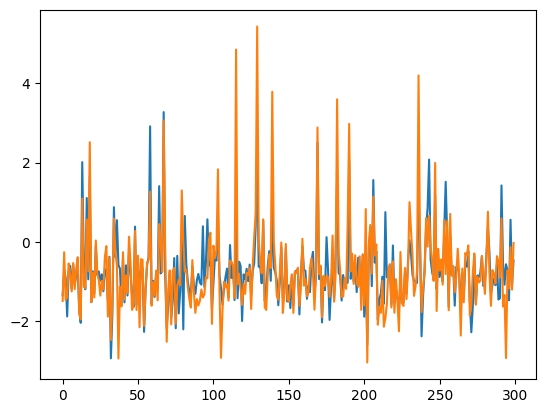

In [116]:
latentA = 9159
latentB = 21728
plt.plot(beta[:,latentA])
plt.plot(beta[:,latentB])

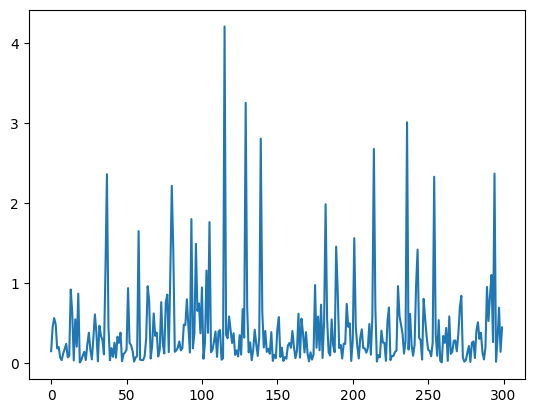

In [117]:
abs_diff = np.abs(beta[:,latentA] - beta[:,latentB]) 
plt.plot(abs_diff)

In [118]:
max_diff_topic = abs_diff.argmax()
print(beta[max_diff_topic, latentA], beta[max_diff_topic, latentB])
np.argsort(beta[max_diff_topic])[::-1][:10]


0.6423185 4.852222


array([24078, 23966,  1032,   674,  3153,  5314,   888, 16369,  3991,
       16147])

## Look at posteriors

I should feed in a bunch of tokens and see what the topic probs are like.

In [128]:
import torch.nn.functional as F

In [120]:
sparse_docs = torch.load('sae_activations/sparse_activations_40960.pt', weights_only=True)
docs = sparse_docs.to_dense()
docs = (docs > 0).float().to(DEVICE)

In [124]:
logtheta_loc, logtheta_scale = prodLDA.encoder(docs)

In [142]:
theta = F.softmax(logtheta_loc, dim=1)

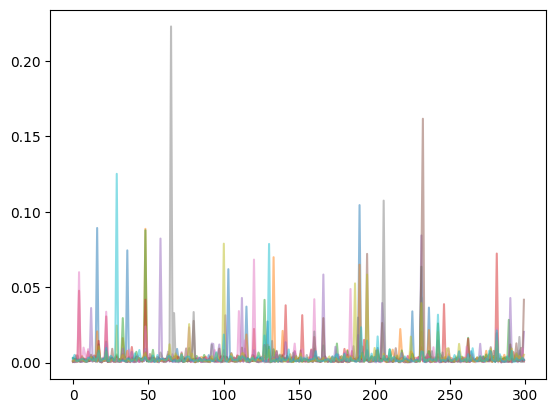

In [143]:
for d in range(10):
    plt.plot(theta[d],alpha=0.5)

In [146]:
np.argmax(theta[:10].numpy().max(-1))

7

## Model in the Loop

In [149]:
import torch
from datasets import load_dataset
from transformer_lens import HookedTransformer
from sae_lens import SAE
from transformer_lens.utils import tokenize_and_concatenate
from tqdm import tqdm
import os


In [152]:
torch.set_grad_enabled(False)

# Set up device
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Device: {device}")


Device: mps


In [153]:

# Load model and SAE
model = HookedTransformer.from_pretrained("gpt2-small", device=device)
sae, cfg_dict, _ = SAE.from_pretrained(
    release="gpt2-small-res-jb",
    sae_id="blocks.8.hook_resid_pre",
    device=device,
)

# Load dataset
dataset = load_dataset(
    path="NeelNanda/pile-10k",
    split="train",
    streaming=False,
)

token_dataset = tokenize_and_concatenate(
    dataset=dataset,
    tokenizer=model.tokenizer,
    streaming=True,
    max_length=sae.cfg.context_size,
    add_bos_token=sae.cfg.prepend_bos,
)


Loaded pretrained model gpt2-small into HookedTransformer


/Users/ghd/dev/MATS/NN-training/SAEs/freq-features/.venv/lib/python3.12/site-packages/sae_lens/sae.py:136: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(
Using the latest cached version of the dataset since NeelNanda/pile-10k couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /Users/ghd/.cache/huggingface/datasets/NeelNanda___pile-10k/default/0.0.0/127bfedcd5047750df5ccf3a12979a47bfa0bafa (last modified on Thu Oct 17 01:38:51 2024).
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [156]:
def layer_activations(model, tokens, layer=8):
    return model.run_with_cache(tokens, return_type="resid_pre", stop_at=layer+1)[0]


In [155]:
x = model.to_tokens("The cat sat on the mat.")
model.run_with_cache

tensor([[50256,   464,  3797,  3332,   319,   262,  2603,    13]],
       device='mps:0')